In [1]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models.inception import inception_v3
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pathlib import Path

%matplotlib inline


In [2]:
is_cuda = torch.cuda.is_available()
is_cuda

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Utility functions

In [4]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)

In [5]:
class LayerActivations():
    features=[]
    
    def __init__(self,model):
        self.features = []
        self.hook = model.register_forward_hook(self.hook_fn)
    
    def hook_fn(self,module,input,output):
        
        self.features.extend(output.view(output.size(0),-1).cpu().data)

    
    def remove(self):
        
        self.hook.remove()

In [6]:
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)

In [7]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.to(device),target.to(device)
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = float(running_loss/len(data_loader.dataset))
    accuracy = float(100. * running_correct/len(data_loader.dataset))
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

## Creating PyTorch datasets

In [8]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [9]:
# For Dogs & Cats dataset
path = Path('../ml_data/dogs_cats/data/')

In [10]:
train_dset = ImageFolder(path/'dogscats/train/',transform=data_transform)
val_dset = ImageFolder(path/'dogscats/valid/',transform=data_transform)
classes=2

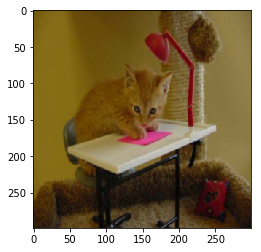

In [11]:
imshow(train_dset[180][0])

## Creating data loader for training and validation datasets

In [12]:
train_loader = DataLoader(train_dset,batch_size=32,shuffle=False,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=32,shuffle=False,num_workers=3)

## Creating Inception V3 model

In [13]:
my_inception = inception_v3(pretrained=True)
my_inception.aux_logits = False
if is_cuda:
    my_inception = my_inception.to(device)

In [27]:
my_inception

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

## Extracting Convolutional features

In [14]:
# Create LayerActivations object to store the output of inception model at a particular layer.
trn_features = LayerActivations(my_inception.Mixed_7c)
trn_labels = []

# Passing all the data through the model , as a side effect the outputs will get stored 
# in the features list of the LayerActivations object. 
for da,la in train_loader:
    _ = my_inception(Variable(da.to(device)))
    trn_labels.extend(la)
trn_features.remove()

# Repeat the same process for validation dataset .

val_features = LayerActivations(my_inception.Mixed_7c)
val_labels = []
for da,la in val_loader:
    _ = my_inception(Variable(da.to(device)))
    val_labels.extend(la)
val_features.remove()

In [15]:
len(val_labels)

2000

In [16]:
trn_features.features[0].size()

torch.Size([131072])

In [17]:
len(trn_features.features)

23000

## Creating train and validation feature dataset

In [18]:
#Dataset for pre computed features for train and validation data sets

trn_feat_dset = FeaturesDataset(trn_features.features,trn_labels)
val_feat_dset = FeaturesDataset(val_features.features,val_labels)

#Data loaders for pre computed features for train and validation data sets

trn_feat_loader = DataLoader(trn_feat_dset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=64)

## A Fully connected network

In [19]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self,in_size,out_size,training=True):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = F.dropout(inp, training=self.training)
        out = self.fc(out)
        return out

# The size of the output from the selected convolution feature 
fc_in_size = 131072

fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.to(device)

In [20]:
optimizer = optim.Adam(fc.parameters(),lr=0.01)

## Train and validate the model

In [21]:

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc.eval(),val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/home/walle/miniconda3/envs/pytorch1_py37/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   8.4 and training accuracy is 20481/23000      89.0
validation loss is   2.2 and validation accuracy is 1915/2000      95.0
training loss is   3.1 and training accuracy is 21968/23000      95.0
validation loss is   2.8 and validation accuracy is 1926/2000      96.0
training loss is   2.0 and training accuracy is 22346/23000      97.0
validation loss is   3.7 and validation accuracy is 1935/2000      96.0
training loss is   1.7 and training accuracy is 22469/23000      97.0
validation loss is   5.9 and validation accuracy is 1890/2000      94.0
training loss is   1.7 and training accuracy is 22548/23000      98.0
validation loss is   4.4 and validation accuracy is 1925/2000      96.0
training loss is   1.1 and training accuracy is 22675/23000      98.0
validation loss is   4.0 and validation accuracy is 1946/2000      97.0
training loss is   1.7 and training accuracy is 22631/23000      98.0
validation loss is   3.5 and validation accuracy is 1945/2000      97.0
traini

In [22]:
optimizer.param_groups[0]['lr']= 0.0001

In [23]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is   1.5 and training accuracy is 22702/23000      98.0
validation loss is   3.2 and validation accuracy is 1960/2000      98.0
training loss is  0.92 and training accuracy is 22791/23000      99.0
validation loss is   2.9 and validation accuracy is 1960/2000      98.0
training loss is  0.81 and training accuracy is 22815/23000      99.0
validation loss is   2.8 and validation accuracy is 1960/2000      98.0
training loss is   0.7 and training accuracy is 22836/23000      99.0
validation loss is   2.7 and validation accuracy is 1963/2000      98.0
training loss is  0.58 and training accuracy is 22854/23000      99.0
validation loss is   2.7 and validation accuracy is 1967/2000      98.0
training loss is  0.58 and training accuracy is 22846/23000      99.0
validation loss is   2.7 and validation accuracy is 1963/2000      98.0
training loss is  0.51 and training accuracy is 22853/23000      99.0
validation loss is   2.8 and validation accuracy is 1960/2000      98.0
traini

In [25]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)



training loss is  0.43 and training accuracy is 22873/23000      99.0
validation loss is   2.8 and validation accuracy is 1966/2000      98.0
training loss is  0.46 and training accuracy is 22887/23000      99.0
validation loss is   2.7 and validation accuracy is 1968/2000      98.0
training loss is  0.48 and training accuracy is 22866/23000      99.0
validation loss is   2.7 and validation accuracy is 1966/2000      98.0
training loss is  0.41 and training accuracy is 22885/23000      99.0
validation loss is   2.8 and validation accuracy is 1967/2000      98.0
training loss is   0.5 and training accuracy is 22857/23000      99.0
validation loss is   2.8 and validation accuracy is 1966/2000      98.0
training loss is   0.4 and training accuracy is 22892/23000      99.0
validation loss is   2.8 and validation accuracy is 1969/2000      98.0
training loss is   0.3 and training accuracy is 22907/23000      99.0
validation loss is   2.8 and validation accuracy is 1967/2000      98.0
traini

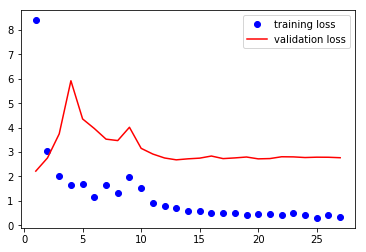

In [26]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()